# 1. 2D Linear Diffusion

We consider the 1d linear Convection equation, under a constant velocity

$$
\partial_t u = \nu \nabla^2 u
$$

In [1]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like
from matplotlib.pyplot import plot, contourf, show, colorbar
%matplotlib inline

In [17]:
# Initial condition
import numpy as np
u0 = lambda x,y: np.exp(-(x-.3)**2/.05**2)*np.exp(-(y-.3)**2/.05**2)

ts = linspace(0., 1., 401)
x,y = np.meshgrid(ts,ts)
u = u0(x,y) 

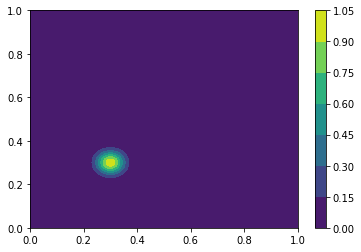

In [18]:
contourf(x,y, u); colorbar() ; show()

### Time scheme

$$\frac{u^{n+1}-u^n}{\Delta t} - \nu \nabla^2 u^{n+1} = 0 $$

$$ \left(I - \nu \Delta t \nabla^2 \right) u^{n+1} = u^n $$

### Weak formulation

$$
\langle v, u^{n+1} \rangle + \nu \Delta t ~ \langle \nabla v, \nabla u^{n+1} \rangle = \langle v, u^n \rangle
$$

expending $u^n$ over the fem basis, we get the linear system

$$A U^{n+1} = M U^n$$

where

$$
M_{ij} = \langle b_i, b_j \rangle
$$

$$
A_{ij} = \langle b_i, b_j \rangle + \nu \Delta t ~ \langle \nabla b_i,  \nabla b_j \rangle
$$


## Abstract Model using SymPDE

In [5]:
from sympde.core import Constant
from sympde.expr import BilinearForm, LinearForm, integral
from sympde.topology import ScalarFunctionSpace, Square, element_of, grad, dot

In [6]:
# ... abstract model
domain = Square()

V = ScalarFunctionSpace('V', domain)

x,y = domain.coordinates

u,v = [element_of(V, name=i) for i in ['u', 'v']]

nu = Constant('nu')
dt = Constant('dt')

# bilinear form
expr = v*u + nu*dt* dot(grad(v), grad(u))
a = BilinearForm((u,v), integral(domain , expr))

# bilinear form for the mass matrix
expr = u*v
m  = BilinearForm((u,v), integral(domain , expr))

# linear form for initial condition
from sympy import exp
expr = exp(-(x-.3)**2/.05**2)*exp(-(y-.3)**2/.05**2)*v
l = LinearForm(v, integral(domain, expr))

## Discretization using Psydac

In [7]:
from psydac.api.discretization import discretize

In [8]:
nu = 0.3   # viscosity
T = 0.02  # T final time
dt = 0.001
niter = int(T / dt)

degree = [3,3]    # spline degree
ncells = [64,64]   # number of elements

In [9]:
# Create computational domain from topological domain
domain_h = discretize(domain, ncells=ncells, comm=None)

# Discrete spaces
Vh = discretize(V, domain_h, degree=degree)

# Discretize the bilinear forms
ah = discretize(a, domain_h, [Vh, Vh])
mh = discretize(m, domain_h, [Vh, Vh])

# Discretize the linear form for the initial condition
lh = discretize(l, domain_h, Vh)

In [11]:
# assemble matrices and convert them to scipy
M = mh.assemble().tosparse()
A = ah.assemble(nu=nu, dt=dt).tosparse()

# assemble the rhs and convert it to numpy array
rhs = lh.assemble().toarray()

In [12]:
from scipy.sparse.linalg import cg, gmres

In [13]:
# L2 projection of the initial condition
un, status = cg(M, rhs, tol=1.e-8, maxiter=5000) 

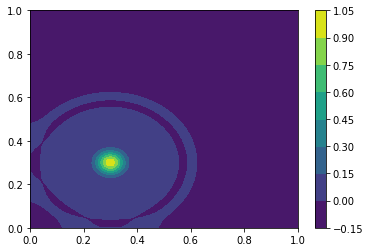

In [14]:
from simplines import plot_field_2d

nbasis = [W.nbasis for W in Vh.spaces]
plot_field_2d(Vh.knots, Vh.degree, un.reshape(nbasis)) ; colorbar() ; show()

In [15]:
for i in range(0, niter):
    b = M.dot(un)
    un, status = gmres(A, b, tol=1.e-8, maxiter=5000)

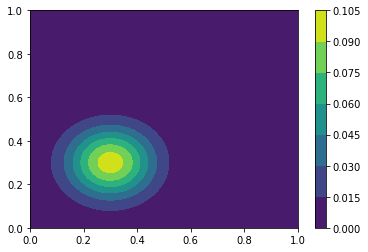

In [16]:
nbasis = [W.nbasis for W in Vh.spaces]
plot_field_2d(Vh.knots, Vh.degree, un.reshape(nbasis)) ; colorbar() ; show()